In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import shutil
import glob
from tqdm import tqdm
import PIL.ExifTags
import PIL.Image
import matplotlib.pyplot as plt

In [2]:
chessboard_size = (9,6)

In [3]:
#Define arrays to save detected points
obj_points = [] #3D points in real world space 
img_points = [] #3D points in image plane
#Prepare grid and points to display
objp = np.zeros((np.prod(chessboard_size),3),dtype=np.float32)

In [4]:
# np.mgird 处理多维张量，每一维的长度跟对应形参(array)的长度一致，该维度的数值在所有其他位置都是该形参的数值
objp[:,:2] = np.mgrid[0:chessboard_size[0],0:chessboard_size[1]].T.reshape(-1,2)
calibration_paths = glob.glob('./chessboards/*')


In [5]:
# 便利所有图片，计算内参
for img_path in tqdm(calibration_paths):
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    print("Image {} Loaded, Analizying . . .".format(img_path))
    # find chessboard corners
    ret,corners = cv2.findChessboardCorners(img_gray,chessboard_size,None)
    if ret == True:
        print("Chessboard found")
        # define criteria for subpixel acc
        # criteria = (type, number of iterations, accuracy)
        criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,30,0.001)
        # refine corner location (to subpixel acc) based on criteria
        cv2.cornerSubPix(img_gray,corners,(5,5),(-1,-1),criteria)
        obj_points.append(objp)
        img_points.append(corners)

  0%|          | 0/4 [00:00<?, ?it/s]

Image ./chessboards/13061174270226992836.jpg Loaded, Analizying . . .


 25%|██▌       | 1/4 [00:08<00:25,  8.64s/it]

Chessboard found
Image ./chessboards/17638001172702260374.jpg Loaded, Analizying . . .


 50%|█████     | 2/4 [00:13<00:14,  7.40s/it]

Chessboard found
Image ./chessboards/18075420161809469314.jpg Loaded, Analizying . . .


 75%|███████▌  | 3/4 [00:22<00:07,  7.91s/it]

Image ./chessboards/8115612997683825456.jpg Loaded, Analizying . . .


100%|██████████| 4/4 [00:32<00:00,  8.14s/it]


In [89]:
# Calibrate camera
# img = cv2.imread(calibration_paths[0])
# img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# ret,corners = cv2.findChessboardCorners(img,(9,6),None)
# print(ret)
ret,K,dist,rvecs,tvecs = cv2.calibrateCamera(obj_points,img_points,img_gray.shape[::-1],None,None)

# Save parameters into numpy file
os.mkdir("./camera_params")
np.save("./camera_params/ret",ret)
np.save("./camera_params/K",K)
np.save("./camera_params/dist",dist)
np.save("./camera_params/rvecs",rvecs)
np.save("./camera_params/tvecs",tvecs)

In [92]:
# img = cv2.imread('./chessboards/tmp.jpeg')


In [73]:
img = cv2.imread(calibration_paths[0])
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret,corners = cv2.findChessboardCorners(img,(9,6),None)

In [97]:
# IphoneX can not get exif data

# exif_img = Image.open(calibration_paths[0])
# exif_data = {
#     PIL.ExifTags.TAGS[k]:v for k,v in exif_img._getexif().items() if k in PIL.ExifTags.TAGS
# }
# focal_length_exif = exif_data['FocalLength']


In [6]:
#Load camera parameters
ret = np.load('./camera_params/ret.npy')
K = np.load('./camera_params/K.npy')
dist = np.load('./camera_params/dist.npy')

img_path1 = "images/1231483327489687587.jpg"
img_path2 = "images/8384447492094200396.jpg"
img1 = cv2.imread(img_path1)
img2 = cv2.imread(img_path2)

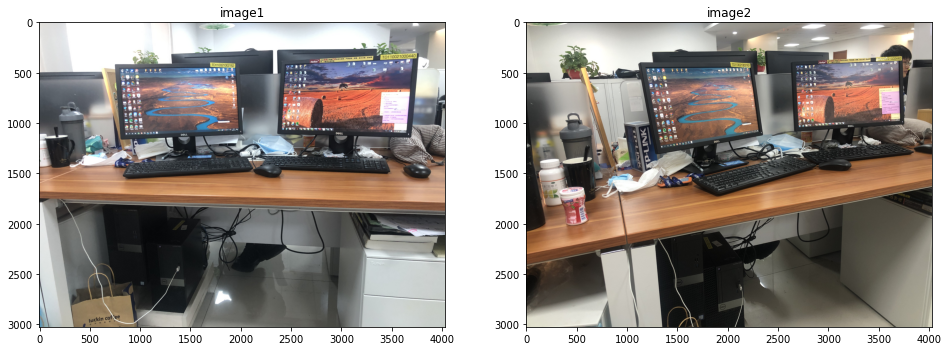

In [7]:
# 打印图片
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title('image1')
plt.imshow(img1[:,:,::-1])
plt.subplot(1,2,2)
plt.title('image2')
plt.imshow(img2[:,:,::-1])
plt.show()

In [8]:
h,w = img1.shape[:2]

In [124]:
# 图像恢复
# Get optimal camera matrix for better undistortion
new_camera_matrix,roi = cv2.getOptimalNewCameraMatrix(K,dist,(w,h),1,(w,h))

# Undistort images
img1_undistorted = cv2.undistort(img1,K,dist,None,new_camera_matrix)
img2_undistorted = cv2.undistort(img2,K,dist,None,new_camera_matrix)

# Downsample each image 3 times (because they are too big)
# img1_sub = 

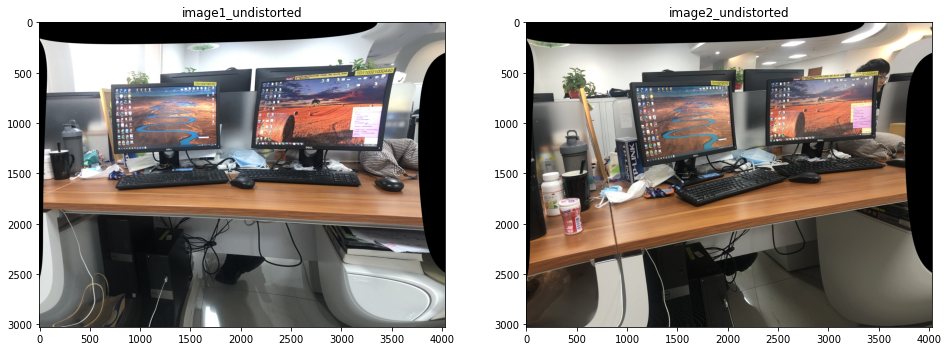

In [125]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title('image1_undistorted')
plt.imshow(img1_undistorted[:,:,::-1])
plt.subplot(1,2,2)
plt.title('image2_undistorted')
plt.imshow(img2_undistorted[:,:,::-1])
plt.show()

Computing the disparity map . . .


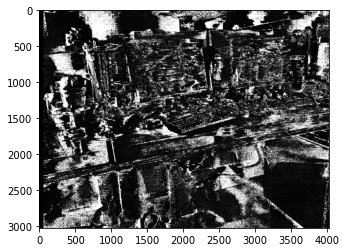

In [10]:
# 显然图片矫正不准
# Set disparity parameters
# what Semi-Global Block Matching are doing ?
# 1 .Prefilter image to normalize brightness and enhance texture
# 2 .Correspondence search along horizontal epipolar lines using a SAD window
# 3 .Postfiltering to eliminate bad correspondence matches.

win_size = 5
min_disp = -1
max_disp = 63 #min_disp * 9
num_disp = max_disp - min_disp 
# create block matching obj
stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
                              numDisparities = num_disp,
                              blockSize = 5,
                              uniquenessRatio = 5,
                              speckleWindowSize = 5,
                              speckleRange = 5,
                              disp12MaxDiff = 1,
                               P1 = 8*3*win_size**2,
                               P2 = 32*3*win_size**2
                               )
print("Computing the disparity map . . .")
disparity_map = stereo.compute(img1,img2)
plt.imshow(disparity_map,'gray')
plt.show()

In [ ]:
# # 计算epipolar line
# sift = cv2.SIFT()
# kp1,dst1 = sift.detectAndCompute(img1,None)
# kp2,dst2 = sift.detectAndCompute(img2,None)
